# Economic News Identification Using an LSTM Neural Network Approach

### Jan Maciejowski, Fabian Perez, Ali Rammal, Louis Golding, Abdullah Ghosheh, Ayah El Barq

# Introduction


The main objective of this project is to create a machine learning model that can automatically classify a given piece of text as either an economical news article or a non-economical news article with a high degree of accuracy. This classification is achieved by training the model on a labeled dataset, where each instance of text is pre-identified relevant or non-relevant. The model learns to recognize patterns and features tied to high context keywords, enabling it to generalize and make accurate predictions on unseen data.

This capability is crucial for applications such as content filtering, media analysis, and information retrieval, where distinguishing between journalistic content and other types of text is necessary. By automating this process, the model aims to assist in efficiently managing and categorizing large volumes of textual data, enhancing the effectiveness of digital content management systems, and providing valuable insights into the nature and distribution of information across various media platforms.







# Preprocess

## Primary Steps
### Packages & NLTK Data Downloads
Aside from the essential packages for data handling and visualization (pandas, numpy, matplotlib), tensorflow keras libraries are used for the completion of the objective, involving tokenizer and pad_sequences. Furthermore, the NLTK library is used for the text cleaning phase in order to fit text into vectorization. Packages such as Punkt - which divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences; Stopwords - removes words that frequently appear in any language or corpus; Wordent -  a lexical database of English which helps find conceptual relationships between words such as hypernyms, hyponyms, synonyms, antonyms etc.

### Variable Selection and Cleaning
As the dataset originally contains 14 variables in total, the most viable decision is to emphasize on the string variables which offer the context for economic newspaper detection. Furthermore, variables ‘text’ and ‘headline’ (the only ones used for model training) offer the needed context for a great generalizable model, while the rest of the variables strongly lack any relevance that facilitates proper predictions due to biased metrics based on low number of survey samples.
	
The ‘relevance’ variable (originally in string type of data) was transformed into a binary variable where (1) = economic newspaper article & (0) = any other. Then, the dataset was reduced into a 50:50 ratio of relevant and non-relevant articles from merging a random sample of non-relevant articles with size length equal to all relevant articles. Headlines and the full text were embedded together into a single string. The training text data was cleaned through extra symbol removal, and split into words for the removal of the stop words and lemmatization. From this point, the text data is classified as clean string data. 

### Tokenization & Padding

This step, also called vectorization, is performed through the tokenizer function form tensorflow turns each string into a sequence of numbers for the model to identify relevant articles with higher frequency of words related to the field of interest. By default, all punctuation is removed, turning the texts into space-separated sequences of words. These sequences are then split into vectorized lists of tokens. They will then be indexed or vectorized. After this process is performed, the train data is prepared for padding.
    
The step of padding the vectorized sequences is required since the model expects similar observation sizes, and the text of each newspaper article is different from each other. For this, the padding process involves identifying the longest sequence and setting all observations to that longest size. Any extra space per observation is deemed a zero. 
	
From this point, our data was split into training, testing, and validation sets for the maximum assurance of our model’s generalizability towards new data. All these steps are seen below.


First, we must read in all necessary packages.

In [85]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Nadam
import tensorflow_addons as tfa

C:\Users\majon\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\majon\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

In addition to that we need some NLTK datasets with english stopword, that must be removed and lemmatized.

In [2]:
# Ensure you have downloaded the necessary NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

Reading the data

In [3]:
df = pd.read_csv("./US-Economic-News.csv", delimiter=',', encoding= 'ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

In [4]:
df.head(5)

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  842613455    False   finalized                   3     12/5/15 17:48   
1  842613456    False   finalized                   3     12/5/15 16:54   
2  842613457    False   finalized                   3      12/5/15 1:59   
3  842613458    False   finalized                   3      12/5/15 2:19   
4  842613459    False   finalized                   3     12/5/15 17:48   

   positivity  positivity:confidence relevance  relevance:confidence  \
0         3.0                 0.6400       yes                 0.640   
1         NaN                    NaN        no                 1.000   
2         NaN                    NaN        no                 1.000   
3         NaN                 0.0000        no                 0.675   
4         3.0                 0.3257       yes                 0.640   

       articleid      date                                           headline  \
0  wsj_398217788   8/14/91              Yields on CDs Fell in the Latest Week   
1  wsj_399019502   8/21/07  The Morning Brief: White House Seeks to Limit ...   
2  wsj_398284048  11/14/91  Banking Bill Negotiators Set Compromise --- Pl...   
3  wsj_397959018   6/16/86  Manager's Journal: Sniffing Out Drug Abusers I...   
4  wsj_398838054   10/4/02  Currency Trading: Dollar Remains in Tight Rang...   

   positivity_gold  relevance_gold  \
0              NaN             NaN   
1              NaN             NaN   
2              NaN             NaN   
3              NaN             NaN   
4              NaN             NaN   

                                                text  
0  NEW YORK -- Yields on most certificates of dep...  
1  The Wall Street Journal Online</br></br>The Mo...  
2  WASHINGTON -- In an effort to achieve banking ...  
3  The statistics on the enormous costs of employ...  
4  NEW YORK -- Indecision marked the dollar's ton...

Removing unneccessary columns.

In [6]:
df = df[['headline', 'text', 'relevance']]

# We drop all irrelavant features to only keep headline and text for 2 reasons: 
# The other features seem either irrelevant or we lack documentation
# With headline and text only, our final model will be more generalizable. We could in theory apply it to any article.

Balancing the dataset to 50% relevant and 50% not relevant.

In [7]:
import pandas as pd
import numpy as np

df_yes = df[df['relevance'] == 'yes']
df_no = df[df['relevance'] == 'no']

df_no_sampled = df_no.sample(n=len(df_yes), random_state=42)

# Concatenate the sampled 'no' rows with all 'yes' rows
df_balanced = pd.concat([df_yes, df_no_sampled])

print(df_balanced['relevance'].value_counts())

relevance
yes    1420
no     1420
Name: count, dtype: int64


In [8]:
df = df_balanced

## Cleaning Strings

Here we merge the title and the full text into one string, we will process in whole.

In [9]:
df['whole_txt'] = df['headline']+ ' ' + df['text']

In [10]:
wtxt_train = np.array(df['whole_txt'])

Removing of special signs, number ect.

In [11]:
for i in range(len(wtxt_train)):
    # Taking out '<br>' in the 'whole_text' column
    wtxt_train[i] = re.sub(r'</?br>', ' ', wtxt_train[i])
    # Deletion of non-latin alfabet signs, also numbers
    wtxt_train[i] = re.sub(r'[^a-zA-Z]', ' ', wtxt_train[i])
    # Removing single letter works like 'a'.
    wtxt_train[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', wtxt_train[i])
    # Removing double spaces
    wtxt_train[i] = re.sub(r'\s+', ' ', wtxt_train[i])
    # Lower case
    wtxt_train[i] = wtxt_train[i].lower()

## Split the words.
We split the string into many strings representing words encoded here as elements of a list.

In [12]:
for i in range(len(wtxt_train)):
    wtxt_train[i] = word_tokenize(wtxt_train[i])

## Removing stop words. 
We are removing stop words like for example: the, they, them, for. Those are words that bring no meritorical value to the articles topic since they are just a non meaning bringing punctuation necessary in the language. By removing them we can also save on size and therefore computational power.

In [13]:
stop_words = set(stopwords.words('english'))

for i in range(len(wtxt_train)):
    wtxt_train[i] = [word for word in wtxt_train[i] if word not in stop_words]

In [14]:
wtxt_train[0]
# stop_words

['yields',
 'cds',
 'fell',
 'latest',
 'week',
 'new',
 'york',
 'yields',
 'certificates',
 'deposit',
 'offered',
 'major',
 'banks',
 'dropped',
 'tenth',
 'percentage',
 'point',
 'latest',
 'week',
 'reflecting',
 'overall',
 'decline',
 'short',
 'term',
 'interest',
 'rates',
 'small',
 'denomination',
 'consumer',
 'cds',
 'sold',
 'directly',
 'banks',
 'average',
 'yield',
 'six',
 'month',
 'deposits',
 'fell',
 'week',
 'ended',
 'yesterday',
 'according',
 'bank',
 'survey',
 'banxquote',
 'money',
 'markets',
 'wilmington',
 'del',
 'information',
 'service',
 'three',
 'month',
 'consumer',
 'deposits',
 'average',
 'yield',
 'sank',
 'week',
 'according',
 'banxquote',
 'two',
 'banks',
 'banxquote',
 'survey',
 'citibank',
 'new',
 'york',
 'corestates',
 'pennsylvania',
 'paying',
 'less',
 'threemonth',
 'small',
 'denomination',
 'cds',
 'declines',
 'somewhat',
 'smaller',
 'five',
 'year',
 'consumer',
 'cds',
 'eased',
 'banxquote',
 'said',
 'yields',
 'three',

## Lemmatization
That means bringing the words with different endings to their initial meaning and form. 

In [15]:
lemmatizer = WordNetLemmatizer()
for i in range(len(wtxt_train)):
    wtxt_train[i] = [lemmatizer.lemmatize(word) for word in wtxt_train[i]]

In [16]:
df['whole_txt'] = wtxt_train
df = df.drop(['headline', 'text'], axis = 1)

In [17]:
df.head(5)

relevance                                          whole_txt
0        yes  [yield, cd, fell, latest, week, new, york, yie...
4        yes  [currency, trading, dollar, remains, tight, ra...
5        yes  [stock, fall, bofa, alcoa, slide, stock, decli...
9        yes  [u, dollar, fall, currency, decline, softened,...
12       yes  [defending, deflation, author, james, stewart,...

### Data preparation
* Initial Data Processing: Our first step is to encode the relevance label into both the Relevant (1) and non-Relevant labels (0). Then, we make it into a np.array to feed into the model.
* Then, we begin to clean text data into pad sequences.

In [18]:
df.update(df["relevance"].apply(lambda x: 0 if x == "no" else 1))

In [19]:
df.head(5)

relevance                                          whole_txt
0          1  [yield, cd, fell, latest, week, new, york, yie...
4          1  [currency, trading, dollar, remains, tight, ra...
5          1  [stock, fall, bofa, alcoa, slide, stock, decli...
9          1  [u, dollar, fall, currency, decline, softened,...
12         1  [defending, deflation, author, james, stewart,...

### Tokenization
First, we need to "tokenize" our sentences, i.e., convert them to sequences of numbers. For this task, we are going to use the `Tokenizer` from Tensorflow (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer))

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wtxt_train)   # fit our tokenizer on the dataset (i.e., assign a number to each word and keep a
                                    # dictionary with the correspondence of each word to a number)

# see the language dictionary and the total number of words (please note that number 0 is reserved for the padding task)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

In [21]:
word_index

{'year': 1,
 'rate': 2,
 'market': 3,
 'said': 4,
 'stock': 5,
 'price': 6,
 'new': 7,
 'economy': 8,
 'economic': 9,
 'month': 10,
 'federal': 11,
 'would': 12,
 'interest': 13,
 'percent': 14,
 'last': 15,
 'week': 16,
 'inflation': 17,
 'bank': 18,
 'billion': 19,
 'fed': 20,
 'dollar': 21,
 'bond': 22,
 'point': 23,
 'growth': 24,
 'investor': 25,
 'one': 26,
 'company': 27,
 'million': 28,
 'index': 29,
 'since': 30,
 'york': 31,
 'quarter': 32,
 'average': 33,
 'first': 34,
 'time': 35,
 'tax': 36,
 'increase': 37,
 'reserve': 38,
 'may': 39,
 'government': 40,
 'president': 41,
 'report': 42,
 'business': 43,
 'day': 44,
 'rose': 45,
 'say': 46,
 'consumer': 47,
 'also': 48,
 'yesterday': 49,
 'two': 50,
 'economist': 51,
 'dow': 52,
 'sale': 53,
 'many': 54,
 'job': 55,
 'fund': 56,
 'share': 57,
 'could': 58,
 'high': 59,
 'gain': 60,
 'higher': 61,
 'trading': 62,
 'cut': 63,
 'deficit': 64,
 'state': 65,
 'analyst': 66,
 'decline': 67,
 'money': 68,
 'spending': 69,
 'fell':

In [22]:
total_words

20936

### Padding Sequences
Sentences and sequences tend to have different lengths, however our model is expecting equally sized observations.
Here we want to convert our texts to sequences and make them of the same length (in general, the lenght of the longest of our sequences). We are going to use here `pad_sequences` from Tensorflow (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)), to add zeroes to the tokenized sentences until they all reach the same length.

In [23]:
sequences = tokenizer.texts_to_sequences(wtxt_train)
padded_sequences = pad_sequences(sequences)

In [24]:
sequences[0]

[143,
 2582,
 70,
 297,
 16,
 7,
 31,
 143,
 2405,
 816,
 932,
 138,
 18,
 299,
 2041,
 286,
 23,
 297,
 16,
 1055,
 400,
 67,
 130,
 74,
 13,
 2,
 214,
 7581,
 47,
 2582,
 609,
 1698,
 18,
 33,
 143,
 285,
 10,
 816,
 70,
 16,
 298,
 49,
 132,
 18,
 247,
 6514,
 68,
 3,
 12016,
 3663,
 743,
 135,
 98,
 10,
 47,
 816,
 33,
 143,
 1832,
 16,
 132,
 6514,
 50,
 18,
 6514,
 247,
 3307,
 7,
 31,
 12017,
 3308,
 1042,
 133,
 12018,
 214,
 7581,
 2582,
 67,
 1020,
 772,
 271,
 1,
 47,
 2582,
 1165,
 6514,
 4,
 143,
 98,
 10,
 285,
 10,
 75,
 174,
 609,
 300,
 1056,
 2042,
 1110,
 286,
 23,
 311,
 16,
 2406]

In [25]:
padded_sequences

array([[    0,     0,     0, ...,   311,    16,  2406],
       [    0,     0,     0, ...,   239,   232,    42],
       [    0,     0,     0, ...,   325,   326,    23],
       ...,
       [    0,     0,     0, ...,   203,  4375,    59],
       [    0,     0,     0, ...,   159,     9,   169],
       [    0,     0,     0, ..., 12015,  7108,  7444]])

In [26]:
df['pad_seq'] = padded_sequences.tolist()

In [27]:
df.drop(['whole_txt'], axis = 1)

relevance                                            pad_seq
0            1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4            1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5            1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9            1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12           1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
...        ...                                                ...
7810         0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
677          0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4794         0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5869         0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2977         0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[2840 rows x 2 columns]

Here we end up with padded sequences and the binarly encoded relevance.

In [28]:
df.head(5)

relevance                                          whole_txt  \
0          1  [yield, cd, fell, latest, week, new, york, yie...   
4          1  [currency, trading, dollar, remains, tight, ra...   
5          1  [stock, fall, bofa, alcoa, slide, stock, decli...   
9          1  [u, dollar, fall, currency, decline, softened,...   
12         1  [defending, deflation, author, james, stewart,...   

                                              pad_seq  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

### Train-Test Split

Over here we do the Train-Test Split, we designate the X and y variables using the padded sequences and revelance respectively. The split is done in proportions 80% to 20% using a random state, in order to mix the relevant and non relevant cases more less equaly by each split. Then from the product of the training split we create another split into the true train part of the data and the validation set, by 80-20% as well. At the end we finish with 3 sets train, validation and test. The sizes of each array are given below. The arrays for the y variable are turned into numpy arrays and they contain only integer values, since those are the only ones tensorflow will accept given a binary crossentropy. 

In [29]:
X = padded_sequences
y = df['relevance']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [32]:
X_train

array([[   0,    0,    0, ...,   61,  362,   66],
       [   0,    0,    0, ..., 4569, 6281, 1252],
       [   0,    0,    0, ..., 3415,   95,    4],
       ...,
       [   0,    0,    0, ...,  479,   96,   64],
       [   0,    0,    0, ...,   27,  246,  609],
       [   0,    0,    0, ...,   10,  391,   24]])

In [33]:
X_train.shape

(1817, 404)

In [34]:
y_train

6965    1
2156    0
1103    0
7486    1
5865    1
       ..
2245    1
1956    1
3711    0
506     1
3821    1
Name: relevance, Length: 1817, dtype: object

In [35]:
y_train.shape

(1817,)

In [36]:
y_val.shape

(455,)

In [37]:
y_test.shape

(568,)

In [38]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [39]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

### Building the model

We are going to build multiple models that include:
- `Embedding` layer with an output representation of each word as a vector of dim 100, 200 or 300
- `LSTM` with an intermediate state of 100 nodes, though this number can vary depending on the model in subject
- An output layer `Dense` that connects the output of the LSTM and creates an output of 1. It either activates if found relevant or not if otherwise. It uses a sigmoid activation which traverses between a 0 and a 1.
- `Dropout` a function that drops a given percentage of links in a random manner after layer training, a good option to try to limit the overfitting effects.
- `Bidirectional` a both way LSTM layer, by that it captures both past and future information to train on.

### Early Stopping
Early Stopping allows us to stop training in order to aviod overfitting as soon as we are getting same or worse loss scores on the validation set. Such a stop is executed when the loss drop occures 3 times in a row. For a poorer accuracy, it restores the previous better weights.

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the models

## Model Building


Regarding model building, we first tried to create a solid model through in depth hyperparameter tuning, but our results were always roughly the same; slightly better than random. We were obtaining training accuracy of 1.0 and test accuracy of 0.83 at most. These results may seem satisfying at first, but we actually had an imbalanced dataset. In fact, our y variable contained 82% of articles that were “economically irrelevant” and only 18% of relevant. Our first intuition was to use 100, 200 or 300 words for the final model in training and to make an excel to keep track of the model parameters used, training parameters and results. 

We then decided to employ regularization methods to reduce over-fitting. We also used graphs to see the loss and what happens at each epoch by defining a history variable and then plotting history when training is done. We did all of this to gain insights and these steps helped us figure out the deeper problem: the imbalance of the y variable in our original dataset. Thus, we finally chose to balance our original dataset by using as many relevant as irrelevant articles, while keeping all of the relevant ones of which we only had 18% in our original dataset. So our final dataset consists of 50% of irrelevant articles and 50% of relevant ones. We then re-ran all our code and models on this new dataset and our results drastically improved, as you can see below.

Other models were run along in different files, using different configurations, however the document you are reading worked the best for our given task, those incluse:
* The original 80 - 20 % Full Text modeling (Worst Performing)
* The 50 - 50 % Full Text modeling (Best Performing, DESCRIBED HERE)
* The 50 - 50 % Headlines Only modeling (Worse Performance by around ~ 10%)
* The 50 - 50 % Headlines + First N Words of Text modeling (Slightly Worse Performance Highly Dependant on the Value of N)
* The 50 - 50 % Full Text 'word2vec' modeling (Depending on model, slightly better or worse)

In the word2vec case we decided to keep it out due to computation complications, not much better results often slightly worse, longer waiting times and over all it increased vastly the model complexity, which we wanted to avoid.

All files can be found on GitHub, some of them are not described and in a more 'dirty' format.

https://github.com/Majon911/EconNewsMLIdent

### MODEL 1 (The base model)

* Our base model defines LSTM as a great foundation for its usability in sequence data such as NLP 
* On the other side, we come with ideally the final output from a classification of all outputs from the LSTM, and use the dense layer to reduce to that one most likely prediction; hence the '1' of output dimension. Finally, the adam optimizer was initialized with, which would tend to overfit through the model training.

- At 56% validation accuracy, this model overfits at 99%.

In [41]:
# We are going to build our model with the Sequential API
model = Sequential()
model.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Change activation based on the number of classes

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model(padded_sequences)

<tf.Tensor: shape=(2840, 1), dtype=float32, numpy=
array([[0.49838775],
       [0.49697223],
       [0.49766093],
       ...,
       [0.49778345],
       [0.4963791 ],
       [0.5038256 ]], dtype=float32)>

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 404, 100)          2093600   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
hist = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val))

Epoch 1/10


57/57 [==============================] - 13s 195ms/step - loss: 0.6880 - accuracy: 0.5498 - val_loss: 0.6759 - val_accuracy: 0.6484
Epoch 2/10
57/57 [==============================] - 9s 162ms/step - loss: 0.5424 - accuracy: 0.7870 - val_loss: 0.6902 - val_accuracy: 0.5978
Epoch 3/10
57/57 [==============================] - 9s 163ms/step - loss: 0.2517 - accuracy: 0.9086 - val_loss: 0.9096 - val_accuracy: 0.6066
Epoch 4/10
57/57 [==============================] - 10s 172ms/step - loss: 0.0673 - accuracy: 0.9818 - val_loss: 1.2419 - val_accuracy: 0.5824
Epoch 5/10
57/57 [==============================] - 10s 172ms/step - loss: 0.0200 - accuracy: 0.9961 - val_loss: 1.4963 - val_accuracy: 0.5670
Epoch 6/10
57/57 [==============================] - 9s 152ms/step - loss: 0.0251 - accuracy: 0.9950 - val_loss: 1.3650 - val_accuracy: 0.5604
Epoch 7/10
57/57 [==============================] - 9s 159ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 1.8727 - val_accuracy: 0.5868
E

In [46]:
hist.history

{'loss': [0.6879979968070984,
  0.5423904061317444,
  0.25165560841560364,
  0.0672721192240715,
  0.01998290978372097,
  0.02507256343960762,
  0.01631668023765087,
  0.007824108004570007,
  0.004535376559942961,
  0.004056017845869064],
 'accuracy': [0.5498073697090149,
  0.7870115637779236,
  0.9086406230926514,
  0.9818381667137146,
  0.9961475133895874,
  0.9950467944145203,
  0.9950467944145203,
  0.9977985620498657,
  0.9988992810249329,
  0.9988992810249329],
 'val_loss': [0.675902247428894,
  0.6902332901954651,
  0.9096015691757202,
  1.2418750524520874,
  1.4963206052780151,
  1.3650264739990234,
  1.8727422952651978,
  1.663246750831604,
  2.076326608657837,
  1.6813592910766602],
 'val_accuracy': [0.6483516693115234,
  0.5978022217750549,
  0.6065934300422668,
  0.5824176073074341,
  0.5670329928398132,
  0.5604395866394043,
  0.58681321144104,
  0.5736263990402222,
  0.5978022217750549,
  0.5692307949066162]}

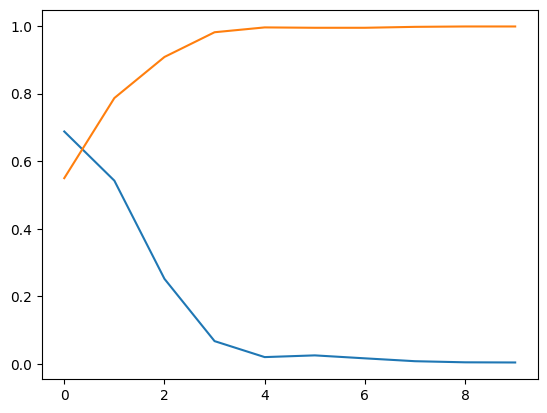

In [47]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])

In [111]:
loss, accuracy = model.evaluate(X_val, y_val)

15/15 [==============================] - 1s 58ms/step - loss: 1.6814 - accuracy: 0.5692


As we can see the model using Adam optimizer, vastly overfits as we can see on the graph, the loss line drops dramatically to nealy 0 just after the first 3 epochs. That had to be changed because with such an agressive rate, we will often overfit and the scores on the validation set were not much better.

### Model 1 Testing

For comparision reasons, we decided to run a test using this model, the test set accuracy is given below and does not stand away from the validation accuracy. The threshold is set to 0.5, that means >0.5 means a positive case, below means a negative case.

In [267]:
loss, accuracy = model.evaluate(X_test, y_test)

18/18 [==============================] - 1s 64ms/step - loss: 1.6087 - accuracy: 0.5757


In [268]:
#Prection and Confusion Matrix
y_pred = model.predict(X_test)
bin_y_pred = (y_pred > 0.5).astype(int)

18/18 [==============================] - 1s 56ms/step


In [269]:
bin_y_pred = np.squeeze(bin_y_pred)

In [270]:
bin_y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,

In [271]:
y_true = y_test
y_pred = bin_y_pred

cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()

print(f"{'':<20}{'Predicted No':<20}{'Predicted Yes':<20}")
print(f"{'Actual No':<20}{TN:<20}{FP:<20}")
print(f"{'Actual Yes':<20}{FN:<20}{TP:<20}")

print("\nPrecision:", round(TP/(TP + FP), 4))
print("Recall:", round(TP/(TP + FN), 4))
print("Accuracy:", round((TP+TN)/(TP + TN + FP + FN), 4))

                    Predicted No        Predicted Yes       
Actual No           152                 130                 
Actual Yes          111                 175                 

Precision: 0.5738
Recall: 0.6119
Accuracy: 0.5757


The precision for the base model is 0.57, above we can see its confusion matrix and precision and recall values.

### MODEL 2

* In this model, the idea of the Dropout layer's implementation is aimed at the reduction of parameter memorization to make the model reduce overfitting with the train data, the 0.2 drops around 20% of the output parameters from the LSTM layer before feeding the Dense layer. This model showed great improvement with 65% validation acuracy.

In [124]:
# We are going to build our model with the Sequential API
model2 = Sequential()

model2.add(Embedding(total_words,      # number of words to process as input
                    50,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model2.add(LSTM(50, return_sequences=False))

model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid')) 

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [125]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 404, 50)           1046800   
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1067051 (4.07 MB)
Trainable params: 1067051 (4.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [126]:
hist2 = model2.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
57/57 [==============================] - 11s 151ms/step - loss: 0.6919 - accuracy: 0.5311 - val_loss: 0.6797 - val_accuracy: 0.6659
Epoch 2/10
57/57 [==============================] - 7s 123ms/step - loss: 0.5895 - accuracy: 0.7369 - val_loss: 0.6224 - val_accuracy: 0.6593
Epoch 3/10
57/57 [==============================] - 7s 125ms/step - loss: 0.3292 - accuracy: 0.8690 - val_loss: 0.8046 - val_accuracy: 0.5978
Epoch 4/10
57/57 [==============================] - 7s 127ms/step - loss: 0.1286 - accuracy: 0.9576 - val_loss: 1.1220 - val_accuracy: 0.5824
Epoch 5/10
57/57 [==============================] - 7s 126ms/step - loss: 0.0530 - accuracy: 0.9862 - val_loss: 1.2956 - val_accuracy: 0.5670


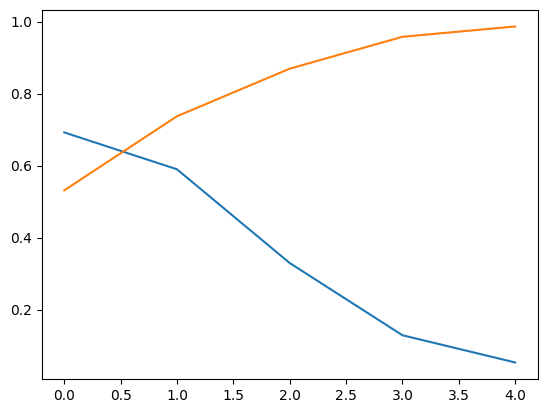

In [127]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['accuracy'])

In [128]:
loss, accuracy = model2.evaluate(X_val, y_val)

15/15 [==============================] - 1s 42ms/step - loss: 0.6224 - accuracy: 0.6593


Thanks to the dropout layer, we reduced the effects of overfitting, and increased our accuracy by a good 5% on validation data. In here we also reduced the number of nodes in the LSTM layer to 50 to try to reduce the effects of overfitting.

### MODEL 3

* Model 3, along with the following models begins to explore the optimization of parameters, given the increase of output representation and a reduction of nodes at the dropout layer. Accuracy: 62%

In [113]:
model3 = Sequential()

model3.add(Embedding(total_words,      # number of words to process as input
                    200,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model3.add(LSTM(200, return_sequences=False))

model3.add(Dropout(0.2))

model3.add(Dense(1, activation='sigmoid')) 

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [114]:
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 404, 200)          4187200   
                                                                 
 lstm_12 (LSTM)              (None, 200)               320800    
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 4508201 (17.20 MB)
Trainable params: 4508201 (17.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
hist3 = model3.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
57/57 [==============================] - 34s 566ms/step - loss: 0.6986 - accuracy: 0.5608 - val_loss: 0.6696 - val_accuracy: 0.6220
Epoch 2/10
57/57 [==============================] - 36s 629ms/step - loss: 0.5054 - accuracy: 0.7947 - val_loss: 0.6990 - val_accuracy: 0.5978
Epoch 3/10
57/57 [==============================] - 34s 606ms/step - loss: 0.1986 - accuracy: 0.9290 - val_loss: 0.9651 - val_accuracy: 0.6110
Epoch 4/10
57/57 [==============================] - 36s 635ms/step - loss: 0.0652 - accuracy: 0.9829 - val_loss: 1.4469 - val_accuracy: 0.6022


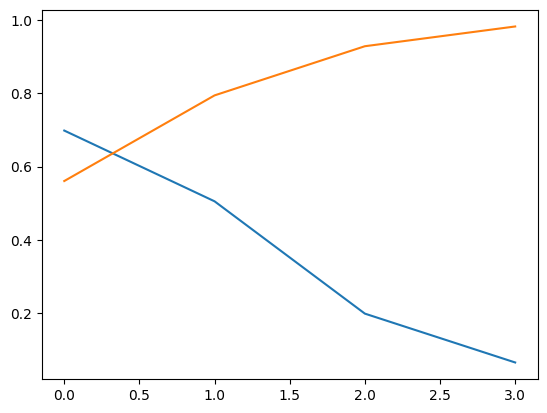

In [116]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['accuracy'])

In [117]:
loss, accuracy = model3.evaluate(X_val, y_val)

15/15 [==============================] - 2s 152ms/step - loss: 0.6696 - accuracy: 0.6220


The increase of the LSTM nodes and the output representation to 200, proved to be a step in the wrong direction, with a 2-3% lower accuracy then model 2. 

### MODEL 4

* Model's 4 change of model compile modifies the type of optimizer to 'sgd' since adam might have given a high learning rate to the model. Accuracy: 49%. The stochastic gradient descent proved to be not a good fit for our model.

In [73]:
model4 = Sequential()

model4.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model4.add(LSTM(100, return_sequences=False))

model4.add(Dense(1, activation='sigmoid')) 

model4.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
hist4 = model4.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/5
57/57 [==============================] - 10s 148ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6930 - val_accuracy: 0.4967
Epoch 2/5
57/57 [==============================] - 8s 139ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6930 - val_accuracy: 0.4879
Epoch 3/5
57/57 [==============================] - 8s 137ms/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6930 - val_accuracy: 0.4901
Epoch 4/5
57/57 [==============================] - 8s 134ms/step - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6930 - val_accuracy: 0.4857


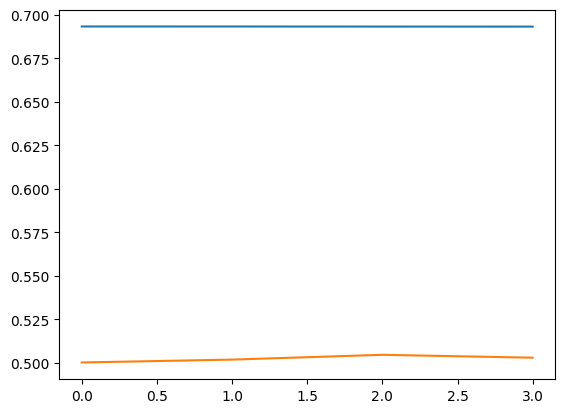

In [76]:
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['accuracy'])

In [118]:
loss, accuracy = model4.evaluate(X_val, y_val)

15/15 [==============================] - 1s 72ms/step - loss: 0.6930 - accuracy: 0.4967


### MODEL 5 (Top Performer)

 * Model 5, deemed to as the Steroid Model, is significantly the best model with a validation `accuracy of 71.9%`. This model is very particular due to its transfer of output dimensions that are back checked from interaction between multiple layers in the model. There are 2 bidirectoinal layers that is filtered through a dropout layer and returned for further refinement. Overall, the data outputs traverse the dropout layer 3 times, which give room to find the keywords perhaps more efficiently than other models.
 * Different values of the output representation, LSTM layer nodes, learning rates and dropout values have been tested, using different optimizers. Adamax with the default learning rate of 0.001, has been found the best performing.
 * 100 in the LSTM layer has been found to be the most efficent.
 * This method also dramatically overfits reaching the train accuracy of 90 at 4th or 5th epoch, but has been found to still capture the most information, out of all tested models.
 * The dropout rate has been set to 0.2, since more strickter dropout rates did not improve the performance.
 * Bidirectional Layers proved to be better performing then one way ones.

In [78]:
adamax_opt = Adamax(learning_rate = 0.001)

In [79]:
model5 = Sequential()

model5.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    mask_zero = True,
                    input_length=len(padded_sequences[0])))    # total length of each observation

model5.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))

model5.add(Dropout(0.2)) 

model5.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)))
#model5.add(LSTM(100, return_sequences=False))

model5.add(Dropout(0.2)) 

model5.add(Dense(1, activation='sigmoid')) 

model5.compile(optimizer=adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 bidirectional (Bidirection  (None, 404, 200)          160800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 404, 200)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [81]:
hist5 = model5.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
57/57 [==============================] - 47s 638ms/step - loss: 0.6855 - accuracy: 0.5394 - val_loss: 0.6210 - val_accuracy: 0.6901
Epoch 2/10
57/57 [==============================] - 35s 609ms/step - loss: 0.5429 - accuracy: 0.7386 - val_loss: 0.5775 - val_accuracy: 0.7187
Epoch 3/10
57/57 [==============================] - 35s 611ms/step - loss: 0.3732 - accuracy: 0.8465 - val_loss: 0.7202 - val_accuracy: 0.6967
Epoch 4/10
57/57 [==============================] - 34s 592ms/step - loss: 0.1863 - accuracy: 0.9329 - val_loss: 0.7666 - val_accuracy: 0.6571
Epoch 5/10
57/57 [==============================] - 33s 574ms/step - loss: 0.0759 - accuracy: 0.9758 - val_loss: 1.0978 - val_accuracy: 0.6615


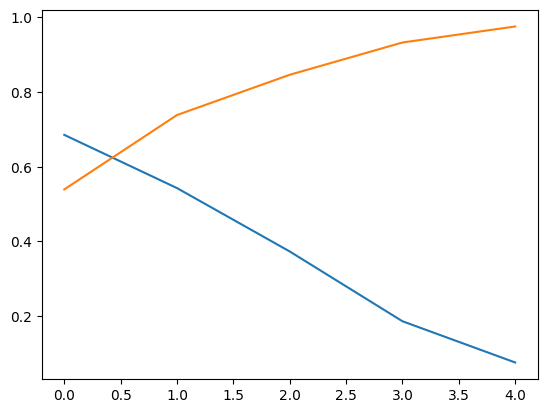

In [82]:
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['accuracy'])

In [119]:
loss, accuracy = model5.evaluate(X_val, y_val)

15/15 [==============================] - 3s 206ms/step - loss: 0.5775 - accuracy: 0.7187


We can see that the loss graph is way more streched out, reducing the previous effects we had using the normal adam optimizer and no dropout. We have less of an overfitting situation. 

### MODEL 6

* Model 6 eplores the modification to improve the hyperparameters of models with output dmension of 50, and and regularized learning rate of adamW optimizer at 0.001.
* Accuracy: 60%
* AdamW is a weight decay technique that penalizes large weigths, in order to prevent the effects of overfitting.
* The 50 nodes in LSTM and output representation have been restored in this case, since they performed the best.

In [86]:
adamw_optimizer = tfa.optimizers.AdamW(learning_rate=1e-2, weight_decay=1e-4)

In [87]:
# We are going to build our model with the Sequential API
model6 = Sequential()

model6.add(Embedding(total_words,      # number of words to process as input
                    50,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model6.add(LSTM(50, return_sequences=False))

model6.add(Dropout(0.2))

model6.add(Dense(1, activation='sigmoid')) 

model6.compile(optimizer= adamw_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 404, 50)           1046800   
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1067051 (4.07 MB)
Trainable params: 1067051 (4.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
hist6 = model6.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
57/57 [==============================] - 9s 124ms/step - loss: 0.6816 - accuracy: 0.5740 - val_loss: 0.6954 - val_accuracy: 0.6044
Epoch 2/10
57/57 [==============================] - 6s 114ms/step - loss: 0.3534 - accuracy: 0.8558 - val_loss: 0.9911 - val_accuracy: 0.5495
Epoch 3/10
57/57 [==============================] - 7s 115ms/step - loss: 0.1327 - accuracy: 0.9466 - val_loss: 1.2453 - val_accuracy: 0.5758
Epoch 4/10
57/57 [==============================] - 7s 117ms/step - loss: 0.0496 - accuracy: 0.9851 - val_loss: 1.3434 - val_accuracy: 0.5604


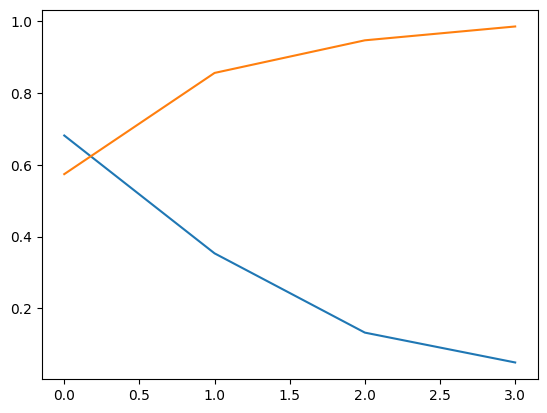

In [90]:
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['accuracy'])

In [120]:
loss, accuracy = model6.evaluate(X_val, y_val)

15/15 [==============================] - 1s 47ms/step - loss: 0.6954 - accuracy: 0.6044


The effects of overfitting are not as well handled as in model 5, as seen in the graph above.

### MODEL 7

* This model once again explores the further regularization of the adamax optimizer at 0.001
* Accuracy: 67%
* The thought is simple, we want to see how the Adamax optimizer performs on a simpler model.
* The 100 in LSTM and output representation / embedding layers proved to work better then 50 for this optimizer.
* Adamax is a much less agressive optimizer with adaptive learning rates, an adress made to the flaws of the original Adam optimizer. 

In [92]:
adamax_opt = Adamax(learning_rate = 0.001)

In [93]:
# We are going to build our model with the Sequential API
model7 = Sequential()

model7.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model7.add(LSTM(100, return_sequences=False))
#model7.add(Bidirectional(LSTM(100, return_sequences=False)))

model7.add(Dropout(0.2))

model7.add(Dense(1, activation='sigmoid')) 

model7.compile(optimizer= adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
hist7 = model7.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 12s 173ms/step - loss: 0.6927 - accuracy: 0.5058 - val_loss: 0.6913 - val_accuracy: 0.5692
Epoch 2/50
57/57 [==============================] - 10s 171ms/step - loss: 0.6547 - accuracy: 0.6979 - val_loss: 0.6336 - val_accuracy: 0.6615
Epoch 3/50
57/57 [==============================] - 10s 178ms/step - loss: 0.5636 - accuracy: 0.7160 - val_loss: 0.6363 - val_accuracy: 0.6703
Epoch 4/50
57/57 [==============================] - 10s 183ms/step - loss: 0.4867 - accuracy: 0.7666 - val_loss: 0.6562 - val_accuracy: 0.6637
Epoch 5/50
57/57 [==============================] - 10s 181ms/step - loss: 0.4207 - accuracy: 0.8162 - val_loss: 0.7302 - val_accuracy: 0.6747


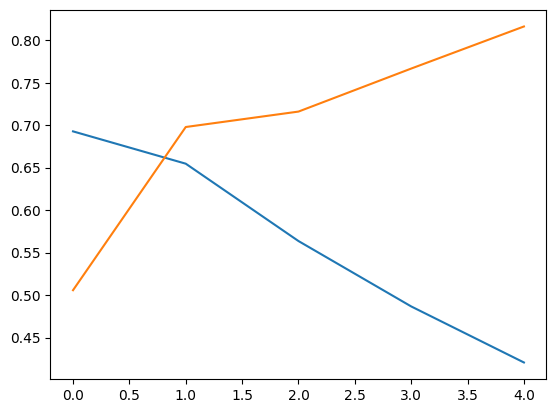

In [96]:
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['accuracy'])

In [121]:
loss, accuracy = model7.evaluate(X_val, y_val)

15/15 [==============================] - 1s 64ms/step - loss: 0.6336 - accuracy: 0.6615


This model performs slightly better then Adam for this exact configuration.

### MODEL 8

* In this model we are testing yet another optimizer, this time the Nadam one.
* Nadam is an optimizer combining two different ones the Nesterov Accelerated Gradient (momentum incorporated) and Adam. NAG updates the parameters using a combination of the current gradient and a fraction of the previous update.
* Accuracy: 65.71%

In [98]:
nadam_opt = Nadam(learning_rate = 0.001)

In [99]:
# We are going to build our model with the Sequential API
model8 = Sequential()

model8.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model8.add(LSTM(100, return_sequences=False))

model8.add(Dropout(0.2))

model8.add(Dense(1, activation='sigmoid')) 

model8.compile(optimizer= nadam_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
model8.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
hist8 = model8.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 13s 194ms/step - loss: 0.6985 - accuracy: 0.5515 - val_loss: 0.6736 - val_accuracy: 0.6571
Epoch 2/20
57/57 [==============================] - 10s 176ms/step - loss: 0.5126 - accuracy: 0.7760 - val_loss: 0.6824 - val_accuracy: 0.6352
Epoch 3/20
57/57 [==============================] - 10s 177ms/step - loss: 0.2061 - accuracy: 0.9241 - val_loss: 1.0434 - val_accuracy: 0.6242
Epoch 4/20
57/57 [==============================] - 10s 177ms/step - loss: 0.0726 - accuracy: 0.9774 - val_loss: 1.2087 - val_accuracy: 0.5868


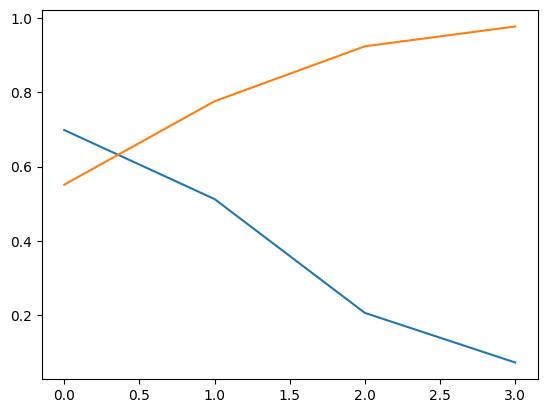

In [102]:
plt.plot(hist8.history['loss'])
plt.plot(hist8.history['accuracy'])

In [122]:
loss, accuracy = model8.evaluate(X_val, y_val)

15/15 [==============================] - 1s 65ms/step - loss: 0.6736 - accuracy: 0.6571


Its performance does not stand out from a normal adam optimizer.

### MODEL 9

* In model 9 we try to containing the simplest best performing model with Adamax 0.001 and try to introduce the Bidirectional layer to the model.
* Accuracy: 68%

In [104]:
adamax_opt = Adamax(learning_rate = 0.001)

In [105]:
# We are going to build our model with the Sequential API
model9 = Sequential()

model9.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

#model9.add(LSTM(100, return_sequences=False))
model9.add(Bidirectional(LSTM(100, return_sequences=False)))

model9.add(Dropout(0.2))

model9.add(Dense(1, activation='sigmoid')) 

model9.compile(optimizer= adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
model9.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
hist9 = model9.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 16s 223ms/step - loss: 0.6931 - accuracy: 0.5146 - val_loss: 0.6911 - val_accuracy: 0.5780
Epoch 2/50
57/57 [==============================] - 12s 208ms/step - loss: 0.6441 - accuracy: 0.6725 - val_loss: 0.6356 - val_accuracy: 0.6835
Epoch 3/50
57/57 [==============================] - 12s 209ms/step - loss: 0.5578 - accuracy: 0.7397 - val_loss: 0.6029 - val_accuracy: 0.6857
Epoch 4/50
57/57 [==============================] - 13s 222ms/step - loss: 0.4707 - accuracy: 0.7942 - val_loss: 0.6156 - val_accuracy: 0.6835
Epoch 5/50
57/57 [==============================] - 12s 220ms/step - loss: 0.3854 - accuracy: 0.8514 - val_loss: 0.7752 - val_accuracy: 0.6659
Epoch 6/50
57/57 [==============================] - 12s 218ms/step - loss: 0.2752 - accuracy: 0.9125 - val_loss: 0.7378 - val_accuracy: 0.6725


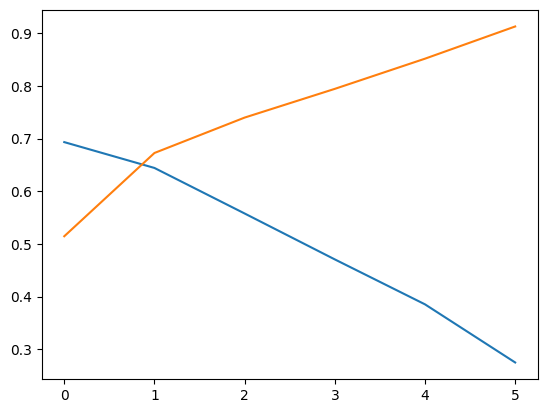

In [108]:
plt.plot(hist9.history['loss'])
plt.plot(hist9.history['accuracy'])

In [123]:
loss, accuracy = model9.evaluate(X_val, y_val)

15/15 [==============================] - 1s 87ms/step - loss: 0.6029 - accuracy: 0.6857


We can see an improvement in the model performance after introducing the Bidirectional Layers.

### MODEL 10 

* Here we try a variation of the best model yet with a change in the LSTM bidirectional layers to 50.
* The performace drops slightly, we will remaind with the previous version.
* Accuracy: 68%

In [134]:
adamax_opt = Adamax(learning_rate = 0.001)

In [135]:
model10 = Sequential()

model10.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    mask_zero = True,
                    input_length=len(padded_sequences[0])))    # total length of each observation

model10.add(Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))

model10.add(Dropout(0.2)) 

model10.add(Bidirectional(tf.keras.layers.LSTM(50, return_sequences=False)))
#model5.add(LSTM(100, return_sequences=False))

model10.add(Dropout(0.2)) 

model10.add(Dense(1, activation='sigmoid')) 

model10.compile(optimizer=adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [136]:
model10.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 404, 100)          2093600   
                                                                 
 bidirectional_7 (Bidirecti  (None, 404, 100)          60400     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 404, 100)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)               

In [137]:
hist10 = model10.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 41s 490ms/step - loss: 0.6856 - accuracy: 0.6098 - val_loss: 0.6623 - val_accuracy: 0.6659
Epoch 2/20
57/57 [==============================] - 23s 403ms/step - loss: 0.5616 - accuracy: 0.7226 - val_loss: 0.5920 - val_accuracy: 0.6791
Epoch 3/20
57/57 [==============================] - 23s 403ms/step - loss: 0.4203 - accuracy: 0.8123 - val_loss: 0.6416 - val_accuracy: 0.6813
Epoch 4/20
57/57 [==============================] - 23s 402ms/step - loss: 0.2511 - accuracy: 0.9114 - val_loss: 0.7972 - val_accuracy: 0.6440
Epoch 5/20
57/57 [==============================] - 23s 411ms/step - loss: 0.1336 - accuracy: 0.9582 - val_loss: 0.9629 - val_accuracy: 0.6220


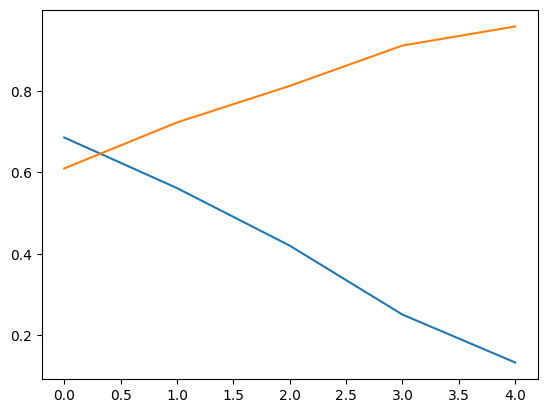

In [138]:
plt.plot(hist10.history['loss'])
plt.plot(hist10.history['accuracy'])

In [139]:
loss, accuracy = model10.evaluate(X_val, y_val)

15/15 [==============================] - 2s 101ms/step - loss: 0.5920 - accuracy: 0.6791


### MODEL 11

* Another variation of model 5, here we are trying to adress the overfitting problem by reducing the learning rate.
* Accuracy: 0.71%

In [149]:
adamax_opt = Adamax(learning_rate = 0.0001)

In [150]:
model11 = Sequential()

model11.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    mask_zero = True,
                    input_length=len(padded_sequences[0])))    # total length of each observation

model11.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))

model11.add(Dropout(0.2)) 

model11.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)))
#model11.add(LSTM(100, return_sequences=False))

model11.add(Dropout(0.2)) 

model11.add(Dense(1, activation='sigmoid')) 

model11.compile(optimizer=adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [151]:
model11.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 404, 100)          2093600   
                                                                 
 bidirectional_15 (Bidirect  (None, 404, 200)          160800    
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 404, 200)          0         
                                                                 
 bidirectional_16 (Bidirect  (None, 200)               240800    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 1)               

In [152]:
hist11 = model11.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 50s 659ms/step - loss: 0.6930 - accuracy: 0.5283 - val_loss: 0.6927 - val_accuracy: 0.5319
Epoch 2/20
57/57 [==============================] - 31s 549ms/step - loss: 0.6920 - accuracy: 0.5795 - val_loss: 0.6923 - val_accuracy: 0.5253
Epoch 3/20
57/57 [==============================] - 31s 550ms/step - loss: 0.6907 - accuracy: 0.5894 - val_loss: 0.6914 - val_accuracy: 0.5341
Epoch 4/20
57/57 [==============================] - 31s 547ms/step - loss: 0.6882 - accuracy: 0.5867 - val_loss: 0.6890 - val_accuracy: 0.5714
Epoch 5/20
57/57 [==============================] - 31s 539ms/step - loss: 0.6813 - accuracy: 0.6170 - val_loss: 0.6808 - val_accuracy: 0.5802
Epoch 6/20
57/57 [==============================] - 31s 553ms/step - loss: 0.6519 - accuracy: 0.6714 - val_loss: 0.6339 - val_accuracy: 0.7033
Epoch 7/20
57/57 [==============================] - 31s 553ms/step - loss: 0.5884 - accuracy: 0.7083 - val_loss: 0.6056 - val_accuracy: 0.6791

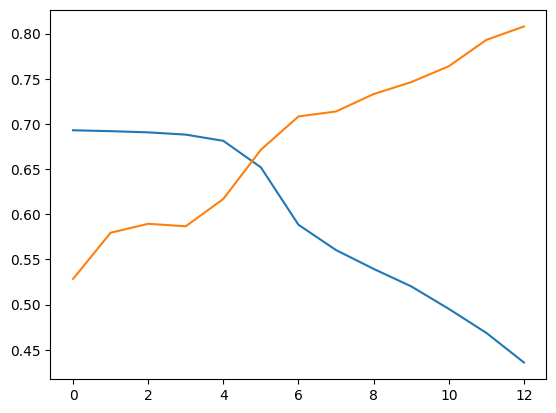

In [153]:
plt.plot(hist11.history['loss'])
plt.plot(hist11.history['accuracy'])

In [154]:
loss, accuracy = model11.evaluate(X_val, y_val)

15/15 [==============================] - 2s 156ms/step - loss: 0.5958 - accuracy: 0.7121


As we can see with this learning rate we do not achieve better performance then with its default value, also there are many hills sygnifying problems with using this learning rate. The loss function at first sees not much improvement to then dramatically fast decrease. That is not an appriciated effect.

### MODEL 12

* For the last model we try different output representation values of 200 and 300, only to see worse performace.
* Accuracy for 300: 67%

In [161]:
adamax_opt = Adamax(learning_rate = 0.001)

In [162]:
# We are going to build our model with the Sequential API
model12 = Sequential()

model12.add(Embedding(total_words,      # number of words to process as input
                    300,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

#model12.add(LSTM(100, return_sequences=False))
model12.add(Bidirectional(LSTM(100, return_sequences=False)))

model12.add(Dropout(0.2))

model12.add(Dense(1, activation='sigmoid')) 

model12.compile(optimizer= adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [163]:
model12.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 404, 300)          6280800   
                                                                 
 bidirectional_18 (Bidirect  (None, 200)               320800    
 ional)                                                          
                                                                 
 dropout_24 (Dropout)        (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 201       
                                                                 
Total params: 6601801 (25.18 MB)
Trainable params: 6601801 (25.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [164]:
hist12 = model12.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 21s 318ms/step - loss: 0.6926 - accuracy: 0.5388 - val_loss: 0.6801 - val_accuracy: 0.6813
Epoch 2/20
57/57 [==============================] - 17s 295ms/step - loss: 0.6032 - accuracy: 0.7160 - val_loss: 0.5951 - val_accuracy: 0.6791
Epoch 3/20
57/57 [==============================] - 17s 303ms/step - loss: 0.4948 - accuracy: 0.7887 - val_loss: 0.6057 - val_accuracy: 0.6901
Epoch 4/20
57/57 [==============================] - 17s 299ms/step - loss: 0.4176 - accuracy: 0.8459 - val_loss: 0.6326 - val_accuracy: 0.6681
Epoch 5/20
57/57 [==============================] - 17s 303ms/step - loss: 0.2975 - accuracy: 0.8943 - val_loss: 0.6705 - val_accuracy: 0.6879


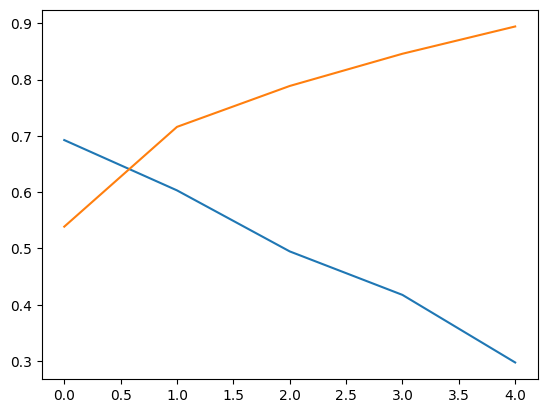

In [165]:
plt.plot(hist12.history['loss'])
plt.plot(hist12.history['accuracy'])

In [166]:
loss, accuracy = model12.evaluate(X_val, y_val)

15/15 [==============================] - 1s 79ms/step - loss: 0.5951 - accuracy: 0.6791


Link to an excel SpreadSheet containing model performance, also with No 50-50 split and title only. Word2vec proved to work similar, depending on the model, 2-3% better or arpund the same worse, therefore we decided to leave it out and use lemmatization.

https://docs.google.com/spreadsheets/d/1Vcnnh5MvkoVpfSyF4jWzxz93QvzuRA8cQcuvnS_GXrk/edit#gid=1601168295

# Testing Our Best Performing Model

As shown above the 5th model proves to be the best performer, we will now proceed to the testing process, where we first check its performance of the test set to then predict the test results, and create a confusion matrix resembling its predictive performance. The threshold is yet again set to 0.5.

In [167]:
loss, accuracy = model5.evaluate(X_test, y_test)

18/18 [==============================] - 3s 153ms/step - loss: 0.5891 - accuracy: 0.6937


In [169]:
#Prection and Confusion Matrix
y_pred = model5.predict(X_test)
bin_y_pred = (y_pred > 0.5).astype(int)

18/18 [==============================] - 7s 148ms/step


In [170]:
bin_y_pred = np.squeeze(bin_y_pred)

In [171]:
y_true = y_test
y_pred = bin_y_pred

In [189]:
cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()

print('Test Set Results:\n')

print(f"{'':<20}{'Predicted No':<20}{'Predicted Yes':<20}")
print(f"{'Actual No':<20}{TN:<20}{FP:<20}")
print(f"{'Actual Yes':<20}{FN:<20}{TP:<20}")

print("\nPrecision:", round(TP/(TP + FP), 4))
print("Recall:", round(TP/(TP + FN), 4))
print("Accuracy:", round((TP+TN)/(TP + TN + FP + FN), 4))

Test Set Results:

                    Predicted No        Predicted Yes       
Actual No           194                 88                  
Actual Yes          86                  200                 

Precision: 0.6944
Recall: 0.6993
Accuracy: 0.6937


In the results above we can see a much more imporved model, with better metrics when compared to the base model. Nearly 70% accuracy, recall and precision. Makes this a well performing model. Especially when compared to others we checked. The test accuracy does not fall out of bounds with the validation result, signaling the validity of the performance of our model outside of the train set, and a good balance of each cases in each of the splits made.  

# Custom Text Import And Prediction

To prove the performance of the model and simply to check its real life purpose, we have checked real recent articles from Bloomberg and CNBC, in both classes of relevancy. First, we created a function in which 3 arguments are provided - the headline string, the text string and the length of padded sequences to set a max article length of 404 words our model can intake. 
* The strings are combined into a single string, then the cleaning process is done, along with removing the stopwords, and lemmatization.
*  An error will be brought out if the length of the given article is > 404 words or the padded sequence length.
*  If however this is not the case we proceed into turning the text into sequences and padding them given the max length given as an argument.
*  As the last step a prediction is made and later classified as Economic or Non Economic depending if the value is smaller or bigger then the threshold of 0.5.
*  The demonstration of the function in work with real articles is given below. 

In [250]:
def is_txt_econ(headline, text, max_l):
    whole_txt = headline + ' ' + text
    
    # Taking out '<br>' in the 'whole_text' column
    whole_txt = re.sub(r'</?br>', ' ', whole_txt)
    # Deletion of non-latin alfabet signs, also numbers
    whole_txt = re.sub(r'[^a-zA-Z]', ' ', whole_txt)
    # Removing single letter works like 'a'.
    whole_txt = re.sub(r"\s+[a-zA-Z]\s+", ' ', whole_txt)
    # Removing double spaces
    whole_txt = re.sub(r'\s+', ' ', whole_txt)
    # Lower case
    whole_txt = whole_txt.lower()
    whole_txt = word_tokenize(whole_txt)
    whole_txt = [word for word in whole_txt if word not in stop_words]
    whole_txt = [lemmatizer.lemmatize(word) for word in whole_txt]

    if len(whole_txt) > max_l:
        print('ERROR, Article lenght must be < 404')
    else:
        sequences = tokenizer.texts_to_sequences([whole_txt])
        padded_sequences = pad_sequences(sequences, maxlen=max_l)
    
        predictions = model5.predict(padded_sequences)
        if predictions < 0.5:
            return(predictions, 'Non Economic')
        else:
            return(predictions, 'Economic')

In [261]:
# Bloomberg Article - Economic Relevance, debatable, about changing structures inside the Swiss bank UBS.
# https://www.bloomberg.com/news/articles/2023-12-03/ubs-s-ermotti-to-find-potential-successor-within-three-years?srnd=premium-europe
is_txt_econ('UBS’s Ermotti to Find Potential Successor Within Three Years', 'Sergio Ermotti, chief executive officer of UBS Group AG, says part of his mandate for the next three years is to identify potential successors, he told the Swiss media outlet Bilanz in a television interview. We need to have candidates that we can assess in the next few years; and it is part of my job to present an array of candidates to the board, Ermotti told the broadcaster. UBS Chairman Colm Kelleher said last week that he, along with the bank’s board, was looking to develop a shortlist of potential successors for 63-year-old Ermotti. Read more: Kelleher Says UBS Could Use Morgan Stanley’s CEO Race Playbook An internal successor would be ideal, Ermotti said in Sunday’s interview, while not ruling out an external candidate. When the bank is successful, it is better to have someone who knows the internal mechanisms, he added. UBS brought back Ermotti as CEO in April to oversee the government-brokered rescue of its smaller competitor Credit Suisse. Ermotti previously ran UBS from 2011 to 2020.', len(padded_sequences[0]))

1/1 [==============================] - 0s 118ms/step


(array([[0.22238688]], dtype=float32), 'Non Economic')

In [262]:
# CNBC - Surely Non Economic, regarding a terrorist attack in Paris
# https://www.cnbc.com/2023/12/03/one-dead-two-injured-after-tourists-attacked-near-paris-eiffel-tower.html
is_txt_econ('One dead, two injured after man attacks tourists near Paris Eiffel Tower', 'One person died and two others were injured after a man attacked tourists in central Paris near the Eiffel Tower, Interior Minister Gerald Darmanin said on Saturday. Police quickly arrested the 26-year-old man, a French national, using a Taser stun gun, Darmanin told reporters. The suspect had been sentenced to four years in prison in 2016 for planning another attack and was on the French security services watch list, and was also known for having psychiatric disorders, the interior minister added.The attack took place around 1900 GMT when the man attacked a tourist couple with a knife on the Quai de Grenelle, a few feet away from the Eiffel Tower, mortally wounding a German national. He was then chased by police and attacked two other people with a hammer before being arrested. The suspect had shouted out Allahu Akbar (God is greatest) and told police he was upset because so many Muslims are dying in Afghanistan and in Palestine and was also upset about the Gaza situation, Darmanin said. The anti-terrorism prosecutors office said it was in charge of the investigation. Saturday nights incident in central Paris occurred less than eight months before the French capital hosts the Olympic Games and could raise questions about security at the global sporting event. Paris plans an unprecedented opening ceremony on the Seine river that may draw as many as 600,000 spectators.', len(padded_sequences[0]))

1/1 [==============================] - 0s 119ms/step


(array([[0.14373618]], dtype=float32), 'Non Economic')

In [263]:
# CNBC, article about rising gold prices due to FED policies.
# https://www.cnbc.com/2023/12/01/gold-set-for-3rd-weekly-gain-as-cooler-data-cements-fed-cut-bets.html
is_txt_econ('Gold hits record high on bets for March start to Fed rate cuts', 'Gold prices rallied to an all-time high on Friday after remarks from Federal Reserve Chair Jerome Powell increased traders confidence the U.S. central bank had completed its monetary policy tightening and could cut rates starting March. Spot gold climbed 1.6% to $2,069.10 per ounce. Prices were 3.4% higher on the week, and earlier rose to $2,075.09 per ounce to beat the previous all-time high of $2,072.49 reached in 2020. U.S. gold futures also settled 1.6% higher at a record peak of $2,089.7. Those records, however, are in nominal terms only. On an inflation-adjusted basis, accounting for the depreciation of the dollar and the effect of higher prices, gold’s all-time was reached in early 1980 at what today would equal $3,452.40 an ounce. Speaking at Spelman College in Atlanta, Powell said the risks of under- and over-tightening are becoming more balanced, but the Fed is not thinking about lowering rates right now. Gold bulls are focusing on Powells comment that [the current] rate is well into restrictive territory, which plays into the narrative that cuts will come sooner, pointedly ignoring his warning that it was premature to speculate on easing rates, said Tai Wong, a New York-based independent metals trader.', len(padded_sequences[0]))

1/1 [==============================] - 0s 100ms/step


(array([[0.5134268]], dtype=float32), 'Economic')

In [264]:
# CNBC Oil Prices Article
# https://www.cnbc.com/2023/12/01/oil-prices-set-to-rise-in-2024-after-opec-voluntary-cuts.html
is_txt_econ('Oil prices could reach $100 a barrel in 2024 if OPEC+ members fulfil pledges for voluntary cuts', 'Oil prices are expected to rise in the new year after some OPEC+ oil producers voluntarily pledged to cut output. The oil cartel on Thursday released a statement that did not formally endorse production cuts, but individual countries announced voluntary reductions totaling 2.2 million barrels per day for the first quarter of 2024. Leading the cuts is OPEC kingpin and largest member Saudi Arabia. Riyadh agreed to extend its voluntary production cut of 1 million barrels per day — which has been in place since July — until the end of the first quarter of 2024. Russia said it will cut supply by 300,000 barrels per day of crude and 200,000 barrels per day of petroleum products over the same period. Iraq is cutting by 223,000 bpd, the United Arab Emirates by 163,000 bpd, Kuwait by 135,000 bpd, Kazakhstan by 82,000 bpd, Algeria by 51,000 bpd and Oman by 42,000 bpd. Compliance is key. It cant just be Saudi Arabia. We have to have compliance from the other OPEC nations, Bill Perkins, CEO and head trader of Skylar Capital Management, told CNBC. When these other nations say theyre going to cut, the market doesnt trust it as much, he added.', len(padded_sequences[0]))

1/1 [==============================] - 0s 103ms/step


(array([[0.7161325]], dtype=float32), 'Economic')

As we can see the algorithm mostly correctly predicts the articles. However, we can see some limitations of such model.
* It can be debatable for some content to be classified as either economic or not for a human, how is a machine supposed to react to that.
* The words that were not in the initial dictionary before training are just simply ignored and their context is not taken into consideration.

As for the recommendations for the future…
* More data, with more economic news, we only had 1420 cases of economic news out of 8000.
* This would allow for a better glossary, therefore likely better predictions.
* Recognize news brands, we only had the Wall Street Journal and the Washington Post. Some brands are strictly financial, while others are not.  